# 2nd CMI-PB Prediction Challenge
### Team Advisor: Barry Grant, Jason Hsiao
### Team member: Peng Cheng, Javier Garcia, Brian Qian, Weikang Guan

## Task 2 Cell frequencies tasks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

## Step 1: Data Cleaning

In [2]:
## Load data into dataframes
df_2020_cell_freq = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_pbmc_cell_frequency.tsv", sep='\t')
df_2020_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_specimen.tsv", sep='\t')
df_2020_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_subject.tsv", sep='\t')
df_2021_cell_freq = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_pbmc_cell_frequency.tsv", sep='\t')
df_2021_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_specimen.tsv", sep='\t')
df_2021_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_subject.tsv", sep='\t')
df_2022_cell_freq = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_pbmc_cell_frequency.tsv", sep='\t')
df_2022_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_specimen.tsv", sep='\t')
df_2022_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_subject.tsv", sep='\t')

In [3]:
#Clean and preprocess the 'subject' dataset.
def clean_df_subject(df):
    """
    Clean and preprocess the 'subject' dataset.

    Parameters:
    - df (DataFrame): Input DataFrame containing 'subject' dataset.

    Returns:
    - df (DataFrame): Cleaned DataFrame with transformed features and encoded categorical columns.
    """
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Extract and calculate age based on 'year_of_birth' and 'date_of_boost'
    df['year_of_birth'] = pd.to_numeric(df['year_of_birth'].str[:4])
    df['date_of_boost'] = pd.to_numeric(df['date_of_boost'].str[:4])
    df['Age'] = df['date_of_boost'] - df['year_of_birth']
    df.drop(['year_of_birth','date_of_boost','dataset'], axis=1, inplace=True)
    
    # Use OneHotEncoder for 'infancy_vac', 'biological_sex', 'ethnicity', and 'race' columns
    columns_to_encode = ['infancy_vac', 'biological_sex', 'ethnicity', 'race']
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    df_encoded = pd.DataFrame(encoder.fit_transform(df[columns_to_encode]), columns=encoder.get_feature_names_out(columns_to_encode))
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=columns_to_encode, inplace=True)
    return df

#Clean and preprocess the 'specimen' dataset.
def clean_df_specimen(df):
    """
    Clean and preprocess the 'specimen' dataset.

    Parameters:
    - df (DataFrame): Input DataFrame containing 'specimen' dataset.

    Returns:
    - df (DataFrame): Cleaned DataFrame with relevant columns and filtered subjects.
    """
    
    # Drop rows with missing values
    df.dropna(inplace=True)

    # Extract rows with 0 or 1 in the "planned_day_relative_to_boost" column
    df = df[(df['planned_day_relative_to_boost'] == 0) | (df['planned_day_relative_to_boost'] == 1)]
    df = df[['specimen_id', 'subject_id', 'actual_day_relative_to_boost', 'planned_day_relative_to_boost']]
    
    # Remove subjects that have either only 0 or only 1 in the "planned_day_relative_to_boost" column
    df = df.groupby('subject_id').filter(lambda x: (0 in x['planned_day_relative_to_boost'].values) and\
                                         (1 in x['planned_day_relative_to_boost'].values))
    return df

#Clean and preprocess the 'cell_freq' dataset.
def clean_df_cell_freq(df):
    """
    Clean and preprocess the 'cell_freq' dataset.

    Parameters:
    - df (DataFrame): Input DataFrame containing 'cell_freq' dataset.

    Returns:
    - df (DataFrame): Cleaned DataFrame with relevant rows containing specific isotype and antigen.
    """
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
     # Extract rows with 'IgG' in the "isotype" column and 'PT' in the "antigen" column
    df = df[(df['cell_type_name'] == 'Monocytes')]
    df = df[['specimen_id', 'percent_live_cell']]
    return df

def merge_df_for_train(df_subject,df_specimen,df_cell_freq):
    """
    Merge cleaned 'subject', 'specimen', and 'cell_freq' datasets into a single DataFrame for training.

    Parameters:
    - df_subject (DataFrame): Cleaned 'subject' dataset.
    - df_specimen (DataFrame): Cleaned 'specimen' dataset.
    - df_cell_freq (DataFrame): Cleaned 'cell_freq' dataset.

    Returns:
    - df (DataFrame): Merged DataFrame containing relevant information for training.
    """
    df = pd.merge(pd.merge(clean_df_cell_freq(df_cell_freq), 
                           clean_df_specimen(df_specimen), on='specimen_id'), 
                  clean_df_subject(df_subject), on='subject_id')
    return df

def clean_merged_df_for_train(df):
    """
    Clean and preprocess the merged DataFrame for training.

    Parameters:
    - df (DataFrame): Merged DataFrame from 'merge_df_for_train' function.

    Returns:
    - df (DataFrame): Cleaned DataFrame with new columns and reordered features for training.
    """
    # New columns:
    # - "Monocytes-D0-cell_freq": cell_freq value on day 0
    # - "actual_boost_day_on_D0": Actual day relative to boost on day 0
    # - "Monocytes-D1-cell_freq": cell_freq value on day 1
    # - "actual_boost_day_on_D1": Actual day relative to boost on day 1
    # - "Monocytes-D1-FC": Log2-fold change between day 1 and day 0 cell_freqs

    
    #create the new column "Monocytes-D0-cell_freq"
    df['Monocytes-D0-cell_freq'] = df.apply(lambda row: df[(df['subject_id'] == row['subject_id']) &\
                                                (df['planned_day_relative_to_boost'] == 0)]\
                                     ['percent_live_cell'].iloc[0]\
                                     if row['planned_day_relative_to_boost'] == 1 else None, axis=1)
    
    #create the new column "actual_day_relative_to_boost_when_day_0" 
    df['actual_boost_day_on_D0'] = df.apply(lambda row: df[(df['subject_id'] ==\
                                                            row['subject_id']) &\
                                            (df['planned_day_relative_to_boost'] == 0)]\
                                            ['actual_day_relative_to_boost'].iloc[0]\
                                            if row['planned_day_relative_to_boost'] == 1 else None, axis=1)
    
    # Drop the "planned_day_relative_to_boost" column
    df.drop('planned_day_relative_to_boost', axis=1, inplace=True)
    
    # Rename columns
    df.rename(columns={'percent_live_cell': 'Monocytes-D1-cell_freq'}, inplace=True)
    df.rename(columns={'actual_day_relative_to_boost': 'actual_boost_day_on_D1'}, inplace=True)

    # Subtract 1 from the values in the "actual_day_relative_to_boost_when_day_1" column
    df['actual_boost_day_on_D1'] = df['actual_boost_day_on_D1'] - 1

    # Drop rows with missing values
    df.dropna(inplace=True)

    # Create a new column by dividing "Monocytes-D1-cell_freq" by "Monocytes-D0-cell_freq" and taking log2
    df['Monocytes-D1-FC'] = np.log2(df['Monocytes-D1-cell_freq'] / df['Monocytes-D0-cell_freq'])

    # Reorder columns for better readability and analysis
    df = df[['subject_id','Monocytes-D1-cell_freq','Monocytes-D1-FC',\
             'Age','biological_sex_Male','infancy_vac_wP',\
             'Monocytes-D0-cell_freq','actual_boost_day_on_D0',\
             'actual_boost_day_on_D1',\
             'ethnicity_Not Hispanic or Latino','ethnicity_Unknown',\
             'race_Black or African American','race_More Than One Race',\
             'race_Native Hawaiian or Other Pacific Islander',\
             'race_Unknown or Not Reported']]
    return df

In [4]:
#clean_df_subject(df_2020_subject)

In [5]:
## Concatenate the cleaned and merged DataFrames for the year 2021 and 2020, then combine both DataFrames into a single training DataFrame (df_train)
df_train = pd.concat([clean_merged_df_for_train(merge_df_for_train(df_2020_subject,df_2020_specimen,df_2020_cell_freq)),\
                      clean_merged_df_for_train(merge_df_for_train(df_2021_subject,df_2021_specimen,df_2021_cell_freq))],\
                     ignore_index=True)
df_train

,subject_id,Monocytes-D1-cell_freq,Monocytes-D1-FC,Age,biological_sex_Male,infancy_vac_wP,Monocytes-D0-cell_freq,actual_boost_day_on_D0,actual_boost_day_on_D1,ethnicity_Not Hispanic or Latino,ethnicity_Unknown,race_Black or African American,race_More Than One Race,race_Native Hawaiian or Other Pacific Islander,race_Unknown or Not Reported
0,29,25.083209,0.640130,19,1.0,0.0,16.094765,-4.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,36,17.446750,0.633829,19,0.0,0.0,11.243799,-6.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,44,35.241054,0.609160,18,0.0,0.0,23.103276,-5.0,0,0.0,0.0,0.0,1.0,0.0,0.0
3,45,13.545087,0.002185,19,0.0,0.0,13.524585,-26.0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,46,30.018793,0.235098,18,0.0,0.0,25.504783,-4.0,0,1.0,0.0,0.0,0.0,0.0,1.0
5,47,8.663056,-0.225578,20,0.0,0.0,10.129240,-13.0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,48,18.252658,0.287020,19,0.0,0.0,14.959751,-63.0,0,1.0,0.0,0.0,0.0,0.0,0.0
7,49,10.347126,-0.512559,20,0.0,0.0,14.760983,-56.0,0,1.0,0.0,0.0,0.0,0.0,0.0
8,52,23.512649,-0.280005,19,1.0,0.0,28.549035,-34.0,0,1.0,0.0,0.0,1.0,0.0,0.0
9,55,15.334381,0.645287,20,0.0,0.0,9.804276,-8.0,0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def merge_df_for_prediction(df_subject,df_specimen,df_cell_freq):
    """
    Merge cleaned 'subject', 'specimen', and 'cell_freq' datasets into a single DataFrame for prediction.

    Parameters:
    - df_subject (DataFrame): Cleaned 'subject' dataset.
    - df_specimen (DataFrame): Cleaned 'specimen' dataset.
    - df_cell_freq (DataFrame): Cleaned 'cell_freq' dataset.

    Returns:
    - df (DataFrame): Merged DataFrame containing relevant information for prediction.
    """
    
    df_specimen_cleaned = clean_df_specimen(df_specimen)
     # Clean 'specimen' dataset and create a new column 'actual_boost_day_on_D1'
    df_specimen_cleaned['actual_boost_day_on_D1'] = df_specimen_cleaned.\
    apply(lambda row: df_specimen_cleaned[(df_specimen_cleaned['subject_id'] == row['subject_id']) &\
          (df_specimen_cleaned['planned_day_relative_to_boost'] == 1)]['actual_day_relative_to_boost'].iloc[0]\
          if row['planned_day_relative_to_boost'] == 0 else None, axis=1)
    
    # Function merges cleaned DataFrames based on 'specimen_id' and 'subject_id'.
    df = pd.merge(pd.merge(clean_df_cell_freq(df_cell_freq), 
                           df_specimen_cleaned, on='specimen_id'), 
                  clean_df_subject(df_subject), on='subject_id')
    return df

def clean_merged_df_for_prediction(df):
    """
    Clean and preprocess the merged DataFrame for prediction.

    Parameters:
    - df (DataFrame): Merged DataFrame from 'merge_df_for_prediction' function.

    Returns:
    - df (DataFrame): Cleaned DataFrame with necessary columns for prediction.
    """
    
    # Drop the "planned_day_relative_to_boost" column
    df.drop('planned_day_relative_to_boost', axis=1, inplace=True)
    
    # Rename columns
    df.rename(columns={'percent_live_cell':'Monocytes-D0-cell_freq'}, inplace=True)
    df.rename(columns={'actual_day_relative_to_boost':'actual_boost_day_on_D0'}, inplace=True)

    df.dropna(inplace=True)
    ## Ensure specific columns exist and create them with default value 0.0 if not
    columns = ['ethnicity_Not Hispanic or Latino','ethnicity_Unknown',\
             'race_Black or African American','race_More Than One Race',\
             'race_Native Hawaiian or Other Pacific Islander',\
             'race_Unknown or Not Reported']
    # Check if columns exist, if not, create them and assign 0.0
    for col in columns:
        if col not in df.columns:
            df[col] = 0.0
        
    # Reorder columns for better readability
    df = df[['subject_id',\
             'Age','biological_sex_Male','infancy_vac_wP',\
             'Monocytes-D0-cell_freq','actual_boost_day_on_D0',\
             'actual_boost_day_on_D1',\
             'ethnicity_Not Hispanic or Latino','ethnicity_Unknown',\
             'race_Black or African American','race_More Than One Race',\
             'race_Native Hawaiian or Other Pacific Islander',\
             'race_Unknown or Not Reported']]
    return df

In [7]:
# Create a prediction DataFrame (df_pred) by cleaning and preprocessing merged DataFrames for the year 2022.

# Clean and preprocess the 'subject', 'specimen', and 'cell_freq' datasets for prediction.
# The 'merge_df_for_prediction' function is used to merge cleaned DataFrames based on 'specimen_id' and 'subject_id'.
# The resulting DataFrame is then cleaned further using the 'clean_merged_df_for_prediction' function.
df_pred = clean_merged_df_for_prediction(merge_df_for_prediction(df_2022_subject,df_2022_specimen,df_2022_cell_freq))
df_pred

,subject_id,Age,biological_sex_Male,infancy_vac_wP,Monocytes-D0-cell_freq,actual_boost_day_on_D0,actual_boost_day_on_D1,ethnicity_Not Hispanic or Latino,ethnicity_Unknown,race_Black or African American,race_More Than One Race,race_Native Hawaiian or Other Pacific Islander,race_Unknown or Not Reported
0,97,35,1.0,1.0,21.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,110,24,0.0,0.0,28.4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,112,25,1.0,0.0,22.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,100,20,0.0,0.0,22.9,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,99,22,0.0,0.0,25.8,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,102,18,1.0,0.0,29.3,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,118,24,1.0,0.0,14.1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,109,32,0.0,1.0,19.4,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,111,25,1.0,1.0,36.2,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,106,25,0.0,0.0,18.5,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


## Step 2: Build Model for Task 1.1 Monocytes-D1-cell_freq-Rank

### Step 2.1: Data Preparation

In [8]:
# Split the training data and test data into features (X) and target variable (y)
# Drop unnecessary columns from X: 'subject_id', 'Monocytes-D1-FC', 'Monocytes-D1-cell_freq'
X = df_train.drop(columns=['subject_id', 'Monocytes-D1-FC', 'Monocytes-D1-cell_freq'])

# Set the target variable (y) to 'Monocytes-D1-cell_freq'
y = df_train['Monocytes-D1-cell_freq']

# Split the data into training and testing sets using train_test_split
# 70% for training and 30% for testing, with a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

scaler = Normalizer()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Selected Features: Index(['Age', 'infancy_vac_wP', 'Monocytes-D0-cell_freq',
       'actual_boost_day_on_D0', 'ethnicity_Not Hispanic or Latino'],
      dtype='object')
Coefficients: [ 29.02316043   0.         162.99069211  30.07055639  12.65816925
   0.         151.6265254    0.           0.           0.
   0.           0.        ]


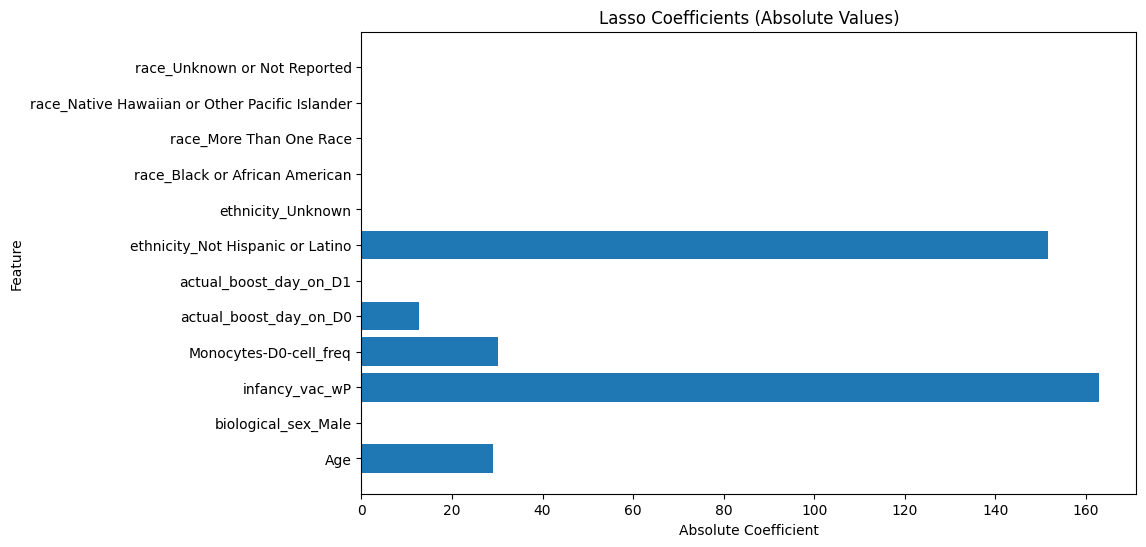

In [9]:
# Use Lasso Regression to select features
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)
lasso_coefficients = lasso_model.coef_
selected_features = X_train_scaled.columns[lasso_coefficients != 0]
X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]

print("Selected Features:", selected_features)
print("Coefficients:", abs(lasso_coefficients))

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), abs(lasso_coefficients), align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Lasso Coefficients (Absolute Values)')
plt.show()

Selected Features: Index(['Age', 'biological_sex_Male', 'infancy_vac_wP',
       'Monocytes-D0-cell_freq', 'actual_boost_day_on_D0',
       'ethnicity_Not Hispanic or Latino'],
      dtype='object')
Feature Importances: [6.09330291e-02 3.84965731e-02 7.88560430e-02 6.87524092e-01
 2.22777171e-02 0.00000000e+00 9.44511250e-02 2.45837415e-03
 2.75742751e-04 1.63176912e-03 0.00000000e+00 1.30955348e-02]


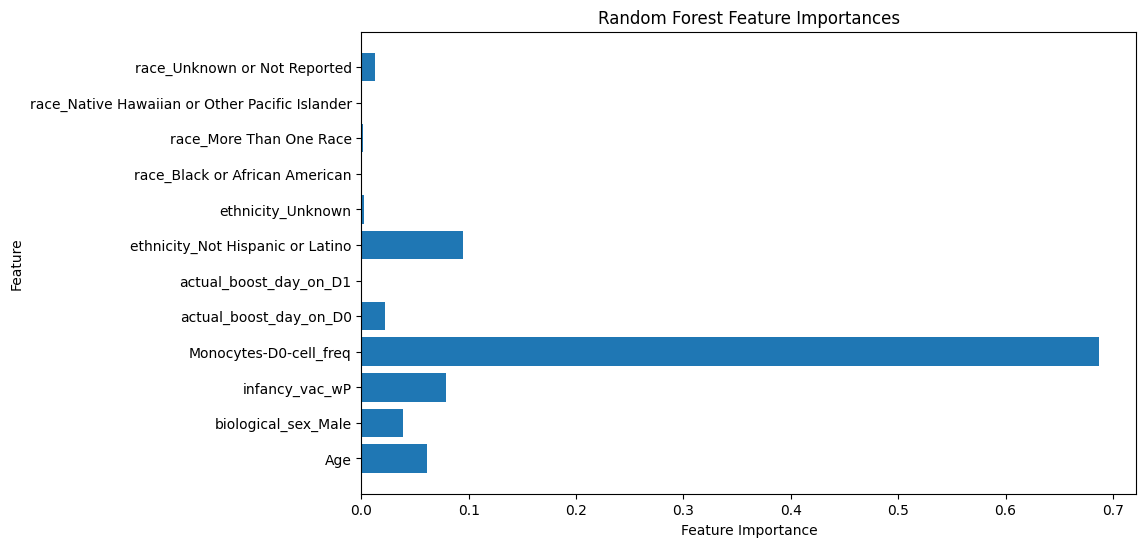

In [10]:
# Use Random Forest Regressor to select features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importances = rf_model.feature_importances_

threshold = 0.015
selected_features = X_train_scaled.columns[feature_importances > threshold]

X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]

print("Selected Features:", selected_features)
print("Feature Importances:", feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), feature_importances, align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


### Step 2.2: Modeling

In [11]:
# Random Forest Regression
rf_model = RandomForestRegressor()
param_dist_rf = {
    'n_estimators': [20,30,40,50,100,200, 300, 400,500,600,700],
    'max_depth': [10,13,15,17,20,22,25,27,30],
    'min_samples_split': [5, 10, 15,17,18,19,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model,
                                      param_distributions=param_dist_rf, 
                                      n_iter=10, 
                                      scoring='r2',  
                                      cv=5, 
                                      random_state=42)
random_search_rf.fit(X_train_scaled_selected, y_train)

# Print best parameters for Random Forest
print("Random Forest - Best Parameters:", random_search_rf.best_params_)

# Evaluate Random Forest on the test set using R-squared
y_pred_rf = random_search_rf.predict(X_test_scaled_selected)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared on Test Set:", r2_rf)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_selected, y_train)

# Evaluate Linear Regression on the test set using R-squared
y_pred_lr = lr_model.predict(X_test_scaled_selected)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - R-squared on Test Set:", r2_lr)

# Support Vector Regression
svr_model = SVR()
param_dist_svr = {
    'C': [5, 10, 15],
    'kernel': ['linear', 'rbf']
}

# Randomized Search CV for SVR
random_search_svr = RandomizedSearchCV(svr_model, param_distributions=param_dist_svr, n_iter=5, scoring='r2', 
                                       cv=5, random_state=42)
random_search_svr.fit(X_train_scaled_selected, y_train)

# Print best parameters for SVR
print("SVR - Best Parameters:", random_search_svr.best_params_)

# Evaluate SVR on the test set using R-squared
y_pred_svr = random_search_svr.predict(X_test_scaled_selected)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR - R-squared on Test Set:", r2_svr)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
param_dist_gb = {
    'n_estimators': [35,36,37,38,39,40,41,42,43],
    'learning_rate': [0.001,0.01,0.02,0.03, 0.05, 0.08,0.1,0.2,0.5,1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4,6,8,10,15,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=10, scoring='r2',  
                                       cv=5, random_state=42)
random_search_gb.fit(X_train_scaled_selected, y_train)

# Print best parameters for Gradient Boosting
print("Gradient Boosting - Best Parameters:", random_search_gb.best_params_)

# Evaluate Gradient Boosting on the test set using R-squared
y_pred_gb = random_search_gb.predict(X_test_scaled_selected)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - R-squared on Test Set:", r2_gb)

# Lasso Regression
lasso_model = Lasso()
param_dist_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Lasso
random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_dist_lasso, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled_selected, y_train)

# Print best parameters for Lasso
print("Lasso - Best Parameters:", random_search_lasso.best_params_)

# Evaluate Lasso on the test set using R-squared
y_pred_lasso = random_search_lasso.predict(X_test_scaled_selected)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso - R-squared on Test Set:", r2_lasso)

# Ridge Regression
ridge_model = Ridge()
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Ridge
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_ridge.fit(X_train_scaled_selected, y_train)

# Print best parameters for Ridge
print("Ridge - Best Parameters:", random_search_ridge.best_params_)

# Evaluate Ridge on the test set using R-squared
y_pred_ridge = random_search_ridge.predict(X_test_scaled_selected)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - R-squared on Test Set:", r2_ridge)

# ElasticNet Regression
elasticnet_model = ElasticNet()
param_dist_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Randomized Search CV for ElasticNet
random_search_elasticnet = RandomizedSearchCV(elasticnet_model, param_distributions=param_dist_elasticnet, n_iter=10, scoring='r2', 
                                               cv=5, random_state=42)
random_search_elasticnet.fit(X_train_scaled_selected, y_train)

# Print best parameters for ElasticNet
print("ElasticNet - Best Parameters:", random_search_elasticnet.best_params_)

# Evaluate ElasticNet on the test set using R-squared
y_pred_elasticnet = random_search_elasticnet.predict(X_test_scaled_selected)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
print("ElasticNet - R-squared on Test Set:", r2_elasticnet)

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4,6,8,10,15,20,25,30,35]
}

# Randomized Search CV for Decision Tree
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='r2', 
                                      cv=5, random_state=42)
random_search_dt.fit(X_train_scaled_selected, y_train)

# Print best parameters for Decision Tree
print("Decision Tree - Best Parameters:", random_search_dt.best_params_)

# Evaluate Decision Tree on the test set using R-squared
y_pred_dt = random_search_dt.predict(X_test_scaled_selected)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree - R-squared on Test Set:", r2_dt)

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
param_dist_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized Search CV for KNN
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, scoring='r2', 
                                        cv=5, random_state=42)
random_search_knn.fit(X_train_scaled_selected, y_train)

# Print best parameters for KNN
print("KNN - Best Parameters:", random_search_knn.best_params_)

# Evaluate KNN on the test set using R-squared
y_pred_knn = random_search_knn.predict(X_test_scaled_selected)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN - R-squared on Test Set:", r2_knn)

# Compare r2 of different models
r2_dict = {'Random Forest': r2_rf, 'Linear Regression': r2_lr, 'SVR': r2_svr, 'Gradient Boosting': r2_gb,
            'Lasso': r2_lasso, 'Ridge': r2_ridge, 'ElasticNet': r2_elasticnet, 
            'Decision Tree': r2_dt, 'KNN': r2_knn}

# Find the model with the highest r2
best_model_name = max(r2_dict, key=r2_dict.get)
best_model = None

# Select the best model
if best_model_name == 'Random Forest':
    best_model = random_search_rf
elif best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'SVR':
    best_model = random_search_svr
elif best_model_name == 'Gradient Boosting':
    best_model = random_search_gb
elif best_model_name == 'Lasso':
    best_model = random_search_lasso
elif best_model_name == 'Ridge':
    best_model = random_search_ridge
elif best_model_name == 'ElasticNet':
    best_model = random_search_elasticnet
elif best_model_name == 'Decision Tree':
    best_model = random_search_dt
elif best_model_name == 'KNN':
    best_model = random_search_knn

print(f"\nBest Model: {best_model_name} with R-squared: {r2_dict[best_model_name]}")

Random Forest - Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 22}
Random Forest - R-squared on Test Set: 0.6313259933293538
Linear Regression - R-squared on Test Set: 0.45730633205444826
SVR - Best Parameters: {'kernel': 'rbf', 'C': 5}
SVR - R-squared on Test Set: 0.43822152283772997
Gradient Boosting - Best Parameters: {'n_estimators': 40, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.05}
Gradient Boosting - R-squared on Test Set: 0.6855810124811261
Lasso - Best Parameters: {'alpha': 0.01}
Lasso - R-squared on Test Set: 0.5167625650981496
Ridge - Best Parameters: {'alpha': 0.01}
Ridge - R-squared on Test Set: 0.5438108314014825
ElasticNet - Best Parameters: {'l1_ratio': 0.3, 'alpha': 0.001}
ElasticNet - R-squared on Test Set: 0.5572446574139964
Decision Tree - Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 20}
Decision Tree - R-squared on Test Set: 0.465383903923569

### Step 2.3: Prediction

In [12]:
# Make prediction
X_new_data_pred = df_pred.drop(columns=['subject_id'])

# Standardize the new input data
X_new_data_scaled_pred = pd.DataFrame(scaler.fit_transform(X_new_data_pred), columns=X_new_data_pred.columns)
X_new_data_scaled_pred = X_new_data_scaled_pred[selected_features.to_list()]

# Use the best model to make predictions
y_pred_new_data_pred = best_model.predict(X_new_data_scaled_pred)
y_pred_new_data_pred

array([23.74894541, 27.88282111, 28.34651874, 23.90634297, 27.88282111,
       36.06193212, 17.34977056, 23.74894541, 36.72409012, 23.70263937,
       23.70263937, 23.90634297, 23.74894541, 30.10181423, 22.94184209,
       19.44566458, 18.89090628, 23.70263937, 23.70263937, 30.10181423,
       29.45942663])

In [13]:
df_pred['Monocytes-D1-cell_freq'] = y_pred_new_data_pred

# Create a copy of the DataFrame
df_pred_cell_freq = df_pred[['subject_id', 'Age', 'biological_sex_Male', 'infancy_vac_wP', 'Monocytes-D1-cell_freq']].copy()
df_pred_cell_freq.loc[:, 'Biological Sex at Birth'] = df_pred_cell_freq['biological_sex_Male']
df_pred_cell_freq.loc[:, 'Vaccine Priming Status'] = df_pred_cell_freq['infancy_vac_wP']
df_pred_cell_freq = df_pred_cell_freq[['subject_id','Age','Biological Sex at Birth','Vaccine Priming Status','Monocytes-D1-cell_freq']]

# Replace values in 'Biological Sex at Birth' column
df_pred_cell_freq['Biological Sex at Birth'] = df_pred_cell_freq['Biological Sex at Birth'].replace({1.0: 'Male', 0.0: 'Female'})

# Replace values in 'Vaccine Priming Status' column
df_pred_cell_freq['Vaccine Priming Status'] = df_pred_cell_freq['Vaccine Priming Status'].replace({1.0: 'wP', 0.0: 'aP'})

# Print the resulting DataFrame
print("Predictions for New Data:")
df_pred_cell_freq

Predictions for New Data:


,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,Monocytes-D1-cell_freq
0,97,35,Male,wP,23.748945
1,110,24,Female,aP,27.882821
2,112,25,Male,aP,28.346519
3,100,20,Female,aP,23.906343
4,99,22,Female,aP,27.882821
5,102,18,Male,aP,36.061932
6,118,24,Male,aP,17.349771
7,109,32,Female,wP,23.748945
8,111,25,Male,wP,36.724090
9,106,25,Female,aP,23.702639


In [14]:
# Rank result
df_pred_cell_freq.loc[:, '1.1) Monocytes-D1-cell_freq-Rank'] = df_pred_cell_freq['Monocytes-D1-cell_freq'].\
                                                     rank(ascending=False, method='max').astype(int)
df_pred_cell_freq = df_pred_cell_freq.drop(columns=['Monocytes-D1-cell_freq'])
df_pred_cell_freq = df_pred_cell_freq.sort_values(by='subject_id')

# Remove the index
df_pred_cell_freq = df_pred_cell_freq.reset_index(drop=True)
df_pred_cell_freq

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.1) Monocytes-D1-cell_freq-Rank
0,97,35,Male,wP,13
1,98,28,Female,wP,20
2,99,22,Female,aP,8
3,100,20,Female,aP,10
4,101,18,Male,aP,10
5,102,18,Male,aP,2
6,103,27,Female,wP,4
7,104,32,Female,wP,18
8,105,27,Female,wP,4
9,106,25,Female,aP,17


## Step 3: Build Model for Task 1.2 Monocytes-D1-cell_freq-FC-Rank

### Step 3.1: Data Preparation

Selected Features: Index(['Age', 'biological_sex_Male', 'infancy_vac_wP',
       'Monocytes-D0-cell_freq', 'actual_boost_day_on_D0',
       'ethnicity_Not Hispanic or Latino', 'race_Black or African American',
       'race_Unknown or Not Reported'],
      dtype='object')
Feature Importances: [0.21208022 0.07213109 0.14035211 0.22160196 0.16029103 0.
 0.12693202 0.00190195 0.01608075 0.01167523 0.         0.03695362]


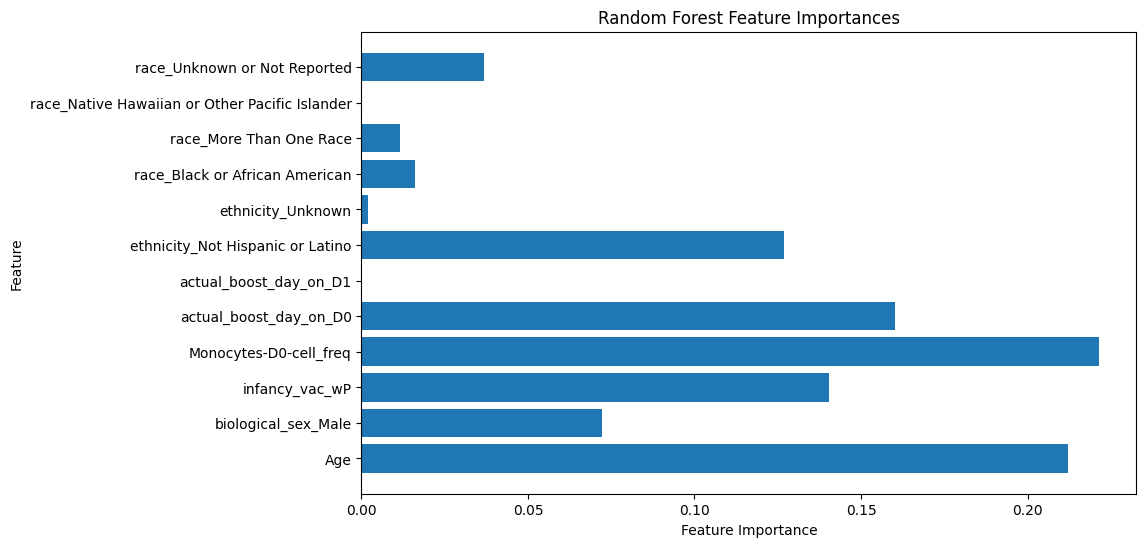

In [15]:
# Split the training data and test data into features (X) and target variable (y)
# Drop unnecessary columns from X: 'subject_id', 'Monocytes-D1-FC', 'Monocytes-D1-cell_freq'
X = df_train.drop(columns=['subject_id', 'Monocytes-D1-FC','Monocytes-D1-cell_freq'])

# Set the target variable (y) to 'Monocytes-D1-FC'
y = df_train['Monocytes-D1-FC']

# Split the data into training and testing sets using train_test_split
# 70% for training and 30% for testing, with a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# Create a Normalizer instance
scaler = Normalizer()

# Scale the features in the training set (X_train) and create a DataFrame with scaled values (X_train_scaled)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale the features in the testing set (X_test) using the previously fitted scaler
# Create a DataFrame with scaled values (X_test_scaled)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Use Random Forest Regressor to select features
# Create a RandomForestRegressor instance with a specified random state
rf_model = RandomForestRegressor(random_state=42)

# Fit the model using the scaled training set features (X_train_scaled) and target variable (y_train)
rf_model.fit(X_train_scaled, y_train)

# Obtain feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Set a threshold for feature selection
threshold = 0.015

# Select features with importances greater than the threshold
selected_features = X_train_scaled.columns[feature_importances > threshold]

# Create new DataFrames with only the selected features
X_train_scaled_selected = X_train_scaled[selected_features]
X_test_scaled_selected = X_test_scaled[selected_features]

# Print selected features and their importances
print("Selected Features:", selected_features)
print("Feature Importances:", feature_importances)

# Plot a horizontal bar chart to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), feature_importances, align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

### Step 3.2: Modeling

In [16]:
## Start modeling using random search cross validaton with several different regression model

# Random Forest Regression
rf_model = RandomForestRegressor()
param_dist_rf = {
    'n_estimators': [20,30,40,50,100,200, 300, 400,500,600,700],
    'max_depth': [10,13,15,17,20,22,25,27,30],
    'min_samples_split': [5, 10, 15,17,18,19,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model,
                                      param_distributions=param_dist_rf, 
                                      n_iter=10, 
                                      scoring='r2',  
                                      cv=5, 
                                      random_state=42)
random_search_rf.fit(X_train_scaled_selected, y_train)

# Print best parameters for Random Forest
print("Random Forest - Best Parameters:", random_search_rf.best_params_)

# Evaluate Random Forest on the test set using R-squared
y_pred_rf = random_search_rf.predict(X_test_scaled_selected)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared on Test Set:", r2_rf)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_selected, y_train)

# Evaluate Linear Regression on the test set using R-squared
y_pred_lr = lr_model.predict(X_test_scaled_selected)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - R-squared on Test Set:", r2_lr)

# Support Vector Regression
svr_model = SVR()
param_dist_svr = {
    'C': [5, 10, 15],
    'kernel': ['linear', 'rbf']
}

# Randomized Search CV for SVR
random_search_svr = RandomizedSearchCV(svr_model, param_distributions=param_dist_svr, n_iter=5, scoring='r2', 
                                       cv=5, random_state=42)
random_search_svr.fit(X_train_scaled_selected, y_train)

# Print best parameters for SVR
print("SVR - Best Parameters:", random_search_svr.best_params_)

# Evaluate SVR on the test set using R-squared
y_pred_svr = random_search_svr.predict(X_test_scaled_selected)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR - R-squared on Test Set:", r2_svr)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
param_dist_gb = {
    'n_estimators': [35,36,37,38,39,40,41,42,43],
    'learning_rate': [0.001,0.01,0.02,0.03, 0.05, 0.08,0.1,0.2,0.5,1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4,6,8,10,15,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=10, scoring='r2',  
                                       cv=5, random_state=42)
random_search_gb.fit(X_train_scaled_selected, y_train)

# Print best parameters for Gradient Boosting
print("Gradient Boosting - Best Parameters:", random_search_gb.best_params_)

# Evaluate Gradient Boosting on the test set using R-squared
y_pred_gb = random_search_gb.predict(X_test_scaled_selected)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - R-squared on Test Set:", r2_gb)

# Lasso Regression
lasso_model = Lasso()
param_dist_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Lasso
random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_dist_lasso, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled_selected, y_train)

# Print best parameters for Lasso
print("Lasso - Best Parameters:", random_search_lasso.best_params_)

# Evaluate Lasso on the test set using R-squared
y_pred_lasso = random_search_lasso.predict(X_test_scaled_selected)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso - R-squared on Test Set:", r2_lasso)

# Ridge Regression
ridge_model = Ridge()
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Ridge
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_ridge.fit(X_train_scaled_selected, y_train)

# Print best parameters for Ridge
print("Ridge - Best Parameters:", random_search_ridge.best_params_)

# Evaluate Ridge on the test set using R-squared
y_pred_ridge = random_search_ridge.predict(X_test_scaled_selected)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - R-squared on Test Set:", r2_ridge)

# ElasticNet Regression
elasticnet_model = ElasticNet()
param_dist_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Randomized Search CV for ElasticNet
random_search_elasticnet = RandomizedSearchCV(elasticnet_model, param_distributions=param_dist_elasticnet, n_iter=10, scoring='r2', 
                                               cv=5, random_state=42)
random_search_elasticnet.fit(X_train_scaled_selected, y_train)

# Print best parameters for ElasticNet
print("ElasticNet - Best Parameters:", random_search_elasticnet.best_params_)

# Evaluate ElasticNet on the test set using R-squared
y_pred_elasticnet = random_search_elasticnet.predict(X_test_scaled_selected)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
print("ElasticNet - R-squared on Test Set:", r2_elasticnet)

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4,6,8,10,15,20,25,30,35]
}

# Randomized Search CV for Decision Tree
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='r2', 
                                      cv=5, random_state=42)
random_search_dt.fit(X_train_scaled_selected, y_train)

# Print best parameters for Decision Tree
print("Decision Tree - Best Parameters:", random_search_dt.best_params_)

# Evaluate Decision Tree on the test set using R-squared
y_pred_dt = random_search_dt.predict(X_test_scaled_selected)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree - R-squared on Test Set:", r2_dt)

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
param_dist_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized Search CV for KNN
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, scoring='r2', 
                                        cv=5, random_state=42)
random_search_knn.fit(X_train_scaled_selected, y_train)

# Print best parameters for KNN
print("KNN - Best Parameters:", random_search_knn.best_params_)

# Evaluate KNN on the test set using R-squared
y_pred_knn = random_search_knn.predict(X_test_scaled_selected)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN - R-squared on Test Set:", r2_knn)

# Compare r2 of different models
r2_dict = {'Random Forest': r2_rf, 'Linear Regression': r2_lr, 'SVR': r2_svr, 'Gradient Boosting': r2_gb,
            'Lasso': r2_lasso, 'Ridge': r2_ridge, 'ElasticNet': r2_elasticnet, 
            'Decision Tree': r2_dt, 'KNN': r2_knn}

# Find the model with the highest r2
best_model_name = max(r2_dict, key=r2_dict.get)
best_model = None

# Select the best model
if best_model_name == 'Random Forest':
    best_model = random_search_rf
elif best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'SVR':
    best_model = random_search_svr
elif best_model_name == 'Gradient Boosting':
    best_model = random_search_gb
elif best_model_name == 'Lasso':
    best_model = random_search_lasso
elif best_model_name == 'Ridge':
    best_model = random_search_ridge
elif best_model_name == 'ElasticNet':
    best_model = random_search_elasticnet
elif best_model_name == 'Decision Tree':
    best_model = random_search_dt
elif best_model_name == 'KNN':
    best_model = random_search_knn

print(f"\nBest Model: {best_model_name} with R-squared: {r2_dict[best_model_name]}")

Random Forest - Best Parameters: {'n_estimators': 400, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_depth': 22}
Random Forest - R-squared on Test Set: -0.2301737146588465
Linear Regression - R-squared on Test Set: -0.07636901504160165
SVR - Best Parameters: {'kernel': 'linear', 'C': 5}
SVR - R-squared on Test Set: 0.3013450147459693
Gradient Boosting - Best Parameters: {'n_estimators': 42, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.001}
Gradient Boosting - R-squared on Test Set: -0.1497009862678491
Lasso - Best Parameters: {'alpha': 0.1}
Lasso - R-squared on Test Set: -0.1542293324457491
Ridge - Best Parameters: {'alpha': 10}
Ridge - R-squared on Test Set: -0.061838085397082576
ElasticNet - Best Parameters: {'l1_ratio': 0.3, 'alpha': 1}
ElasticNet - R-squared on Test Set: -0.1542293324457491
Decision Tree - Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 35, 'max_depth': 30}
Decision Tree - R-squared on Test Set: -0.154229332

### Step 3.3: Prediction

In [17]:
df_pred

,subject_id,Age,biological_sex_Male,infancy_vac_wP,Monocytes-D0-cell_freq,actual_boost_day_on_D0,actual_boost_day_on_D1,ethnicity_Not Hispanic or Latino,ethnicity_Unknown,race_Black or African American,race_More Than One Race,race_Native Hawaiian or Other Pacific Islander,race_Unknown or Not Reported,Monocytes-D1-cell_freq
0,97,35,1.0,1.0,21.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.748945
1,110,24,0.0,0.0,28.4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,27.882821
2,112,25,1.0,0.0,22.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,28.346519
3,100,20,0.0,0.0,22.9,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.906343
4,99,22,0.0,0.0,25.8,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,27.882821
5,102,18,1.0,0.0,29.3,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,36.061932
6,118,24,1.0,0.0,14.1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17.349771
7,109,32,0.0,1.0,19.4,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.748945
8,111,25,1.0,1.0,36.2,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,36.724090
9,106,25,0.0,0.0,18.5,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.702639


In [18]:
# Make prediction
X_new_data_pred = df_pred.drop(columns=['subject_id'])

# Standardize the new input data
X_new_data_scaled_pred = pd.DataFrame(scaler.fit_transform(X_new_data_pred), columns=X_new_data_pred.columns)
X_new_data_scaled_pred = X_new_data_scaled_pred[selected_features.to_list()]
X_new_data_scaled_pred

,Age,biological_sex_Male,infancy_vac_wP,Monocytes-D0-cell_freq,actual_boost_day_on_D0,ethnicity_Not Hispanic or Latino,race_Black or African American,race_Unknown or Not Reported
0,0.740500,0.021157,0.021157,0.444300,0.0,0.021157,0.0,0.000000
1,0.516277,0.000000,0.000000,0.610928,0.0,0.000000,0.0,0.000000
2,0.571210,0.022848,0.000000,0.502665,0.0,0.022848,0.0,0.000000
3,0.516756,0.000000,0.000000,0.591685,0.0,0.025838,0.0,0.000000
4,0.500894,0.000000,0.000000,0.587413,0.0,0.000000,0.0,0.022768
5,0.361016,0.020056,0.000000,0.587653,0.0,0.020056,0.0,0.000000
6,0.730694,0.030446,0.000000,0.429283,0.0,0.030446,0.0,0.000000
7,0.721451,0.000000,0.022545,0.437380,0.0,0.022545,0.0,0.000000
8,0.435981,0.017439,0.017439,0.631301,0.0,0.017439,0.0,0.000000
9,0.638915,0.000000,0.000000,0.472797,0.0,0.025557,0.0,0.000000


In [19]:
# Use the best model to make predictions
y_pred_new_data_pred = best_model.predict(X_new_data_scaled_pred)
y_pred_new_data_pred

array([0.33661265, 0.20721671, 0.24800281, 0.195159  , 0.22020957,
       0.13942089, 0.32966592, 0.32867419, 0.15925978, 0.28072893,
       0.22699119, 0.19754863, 0.33105072, 0.24231934, 0.35050493,
       0.39031795, 0.35691901, 0.21294587, 0.25279769, 0.2237874 ,
       0.2553697 ])

In [20]:
# Update the 'Monocytes-D1-FC' column with predicted values
df_pred['Monocytes-D1-FC'] = y_pred_new_data_pred

# Create a copy of the DataFrame
df_pred_FC = df_pred[['subject_id', 'Age', 'biological_sex_Male', 'infancy_vac_wP', 'Monocytes-D1-FC']].copy()
df_pred_FC.loc[:, 'Biological Sex at Birth'] = df_pred_FC['biological_sex_Male']
df_pred_FC.loc[:, 'Vaccine Priming Status'] = df_pred_FC['infancy_vac_wP']
df_pred_FC = df_pred_FC[['subject_id','Age','Biological Sex at Birth','Vaccine Priming Status','Monocytes-D1-FC']]

# Replace values in 'Biological Sex at Birth' column
df_pred_FC['Biological Sex at Birth'] = df_pred_FC['Biological Sex at Birth'].replace({1.0: 'Male', 0.0: 'Female'})

# Replace values in 'Vaccine Priming Status' column
df_pred_FC['Vaccine Priming Status'] = df_pred_FC['Vaccine Priming Status'].replace({1.0: 'wP', 0.0: 'aP'})

# Print the resulting DataFrame
print("Predictions for New Data:")
df_pred_FC

Predictions for New Data:


,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,Monocytes-D1-FC
0,97,35,Male,wP,0.336613
1,110,24,Female,aP,0.207217
2,112,25,Male,aP,0.248003
3,100,20,Female,aP,0.195159
4,99,22,Female,aP,0.220210
5,102,18,Male,aP,0.139421
6,118,24,Male,aP,0.329666
7,109,32,Female,wP,0.328674
8,111,25,Male,wP,0.159260
9,106,25,Female,aP,0.280729


In [21]:
# Rank the 'Monocytes-D1-FC' values and add a new column with ranks
df_pred_FC.loc[:, '1.2) Monocytes-D1-FC-Rank'] = df_pred_FC['Monocytes-D1-FC'].\
                                                     rank(ascending=False, method='max').astype(int)

# Drop the original 'Monocytes-D1-FC' column
df_pred_FC = df_pred_FC.drop(columns=['Monocytes-D1-FC'])

# Sort the DataFrame by 'subject_id'
df_pred_FC = df_pred_FC.sort_values(by='subject_id')

# Reset the index to remove any existing index
df_pred_FC = df_pred_FC.reset_index(drop=True)
df_pred_FC

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.2) Monocytes-D1-FC-Rank
0,97,35,Male,wP,4
1,98,28,Female,wP,2
2,99,22,Female,aP,15
3,100,20,Female,aP,19
4,101,18,Male,aP,18
5,102,18,Male,aP,21
6,103,27,Female,wP,12
7,104,32,Female,wP,3
8,105,27,Female,wP,14
9,106,25,Female,aP,8


In [22]:
# Merge the predicted cell_freq DataFrame with the ranked Monocytes-D1-FC DataFrame
df_task1 = pd.merge(df_pred_cell_freq, df_pred_FC[['subject_id', '1.2) Monocytes-D1-FC-Rank']], on='subject_id')

# Display the resulting DataFrame for Task 1
df_task1

,subject_id,Age,Biological Sex at Birth,Vaccine Priming Status,1.1) Monocytes-D1-cell_freq-Rank,1.2) Monocytes-D1-FC-Rank
0,97,35,Male,wP,13,4
1,98,28,Female,wP,20,2
2,99,22,Female,aP,8,15
3,100,20,Female,aP,10,19
4,101,18,Male,aP,10,18
5,102,18,Male,aP,2,21
6,103,27,Female,wP,4,12
7,104,32,Female,wP,18,3
8,105,27,Female,wP,4,14
9,106,25,Female,aP,17,8
